# PreTrain

In [2]:
import os, sys, configparser, logging, argparse, time
sys.path.append('/'.join(os.getcwd().split('/')[:-2]))

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim

from XAE.dataset import rmMNIST
from XAE.dataset import MNIST
from XAE.util import init_params

import numpy as np
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

%matplotlib inline

In [3]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
y_dim = 4

d = 64
embed_data = nn.Sequential(
    nn.Conv2d(1, d, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(d),
    nn.ReLU(True),

    nn.Conv2d(d, d, kernel_size = 4, padding = 'same', bias = False),
    nn.BatchNorm2d(d),
    nn.ReLU(True),

    nn.Conv2d(d, 2*d, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(2*d),
    nn.ReLU(True),

    nn.Conv2d(2*d, 2*d, kernel_size = 4, padding = 'same', bias = False),
    nn.BatchNorm2d(2*d),
    nn.ReLU(True),

    nn.Flatten(),
).to(device)

embed_condition = nn.Sequential(
    nn.Linear(49*2*d, d),
    nn.BatchNorm1d(d),
    nn.ReLU(True),
    
    nn.Linear(d, y_dim),
).to(device)

enc_activation = nn.Sequential(
    nn.BatchNorm1d(y_dim),
    nn.ReLU(True),
    nn.Linear(y_dim, 10),
).to(device)

init_params(embed_data)
init_params(embed_condition)
init_params(enc_activation)

In [22]:
labeled_class = [0,1,2,3,4,5,6,7,8,9]
train_data = rmMNIST('./data/MNIST', train = True, label = True, aux = [labeled_class, []], portion = 1.0)
train_generator = torch.utils.data.DataLoader(train_data, 100, num_workers = 5, shuffle = True, pin_memory=True, drop_last=True)

In [23]:
def kk(x, y, diag = True):
    stat = 0.
    for scale in [.1, .2, .5, 1., 2., 5., 10.]:
        C = scale*2*y_dim*2
        kernel = (C/(C + (x.unsqueeze(0) - y.unsqueeze(1)).pow(2).sum(dim = 2)))
        if diag:
            stat += kernel.sum()
        else:
            stat += kernel.sum() - kernel.diag().sum()
    return stat

In [24]:
epoch = 20
opt = optim.Adam(list(embed_data.parameters()) + list(embed_condition.parameters()) + list(enc_activation.parameters()), lr = 1e-3, betas = (0.9, 0.999))
crit = nn.CrossEntropyLoss()
running_loss = 0.0

for k in range(epoch):
    for i, (data, condition) in enumerate(train_generator):
        opt.zero_grad()
        n = len(data)
        x = data.to(device)
        y = condition.to(device)
        
        xx = embed_condition(embed_data(x))
        output = enc_activation(xx)
        loss = crit(output, y)
        loss.backward()
        opt.step()
        running_loss += loss.item()
        
    print('[%d] loss: %.3f' % (k + 1, running_loss / len(train_generator)))
    running_loss = 0.0

[1] loss: 1.751
[2] loss: 0.911
[3] loss: 0.395
[4] loss: 0.243
[5] loss: 0.149
[6] loss: 0.063
[7] loss: 0.036
[8] loss: 0.024
[9] loss: 0.018
[10] loss: 0.016
[11] loss: 0.012
[12] loss: 0.009
[13] loss: 0.008
[14] loss: 0.009
[15] loss: 0.006
[16] loss: 0.006
[17] loss: 0.008
[18] loss: 0.006
[19] loss: 0.004
[20] loss: 0.003


In [25]:
batch_size = 100
test_data = MNIST('./data/MNIST', train = False, label = True)
test_generator = torch.utils.data.DataLoader(test_data, batch_size, num_workers = 5, shuffle = False, pin_memory=True, drop_last=True)
n = len(test_generator)

a, b = next(iter(test_generator))
embed_condition(embed_data(a.to(device))).shape

torch.Size([100, 4])

In [26]:
f1 = np.zeros((0, 10))
f2 = np.zeros((0, y_dim))

i = 0
for a, b in test_generator:
    f1x = b.to('cpu').detach().numpy()
    f2x = embed_condition(embed_data(a.to(device))).to('cpu').detach().numpy()
    f1 = np.concatenate((f1, f1x), axis = 0)
    f2 = np.concatenate((f2, f2x), axis = 0)
    i += 1
    if i == 5:
        break
        
digit = np.arange(10)
lab = [digit[l.astype(np.bool_)] for l in f1]
lab = np.concatenate(lab)

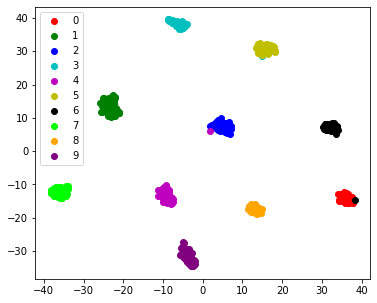

In [27]:
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(f2)

target_ids = list(range(10))

plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'lime', 'orange', 'purple'
for i, c in zip(target_ids, colors):
    plt.scatter(X_2d[lab == i, 0], X_2d[lab == i, 1], c=c, label=str(i))
plt.legend()
plt.show()

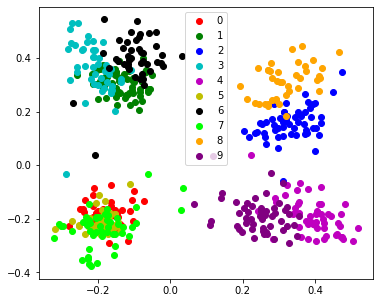

In [28]:
plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'lime', 'orange', 'purple'
for i, c in zip(target_ids, colors):
    plt.scatter(f2[lab == i, 0], f2[lab == i, 2], c=c, label=str(i))
plt.legend()
plt.show()

In [29]:
labeled_class = [0,1,2,3,4,5,6,7,8,9]
train_data = rmMNIST('./data/MNIST', train = True, label = True, aux = [labeled_class, []], portion = 1.0, class_no = True)
train_generator = torch.utils.data.DataLoader(train_data, 100, num_workers = 5, shuffle = True, pin_memory=True, drop_last=True)

In [30]:
ys = np.zeros((10, y_dim))
cs = np.zeros(10)
covs = np.zeros((10, y_dim, y_dim))

for data, condition in train_generator:
    n = len(data)
    x = data.to(device)
    y = condition.to(device)
    z = embed_condition(embed_data(x))
    labs, idxs, counts = y.unique(dim = 0, return_inverse = True, return_counts = True)
    idxs = labs[idxs].view(n,1).expand(-1, y_dim)
    cc = torch.zeros((10, y_dim), dtype = torch.float).to(device).scatter_add_(0, idxs, z)
    ys += cc.detach().to('cpu').numpy()
    cs += counts[labs].detach().to('cpu').numpy()
    
    for i in range(10):
        cov = torch.cov(z[y==i,:].T, correction=0) * torch.sum(y==i)
        covs[i,:,:] += cov.detach().to('cpu').numpy()

In [31]:
w1 = torch.Tensor(ys.transpose()/cs)
w1

tensor([[-0.1712, -0.1225,  0.3385, -0.2133,  0.4019, -0.1858, -0.0899, -0.1789,
          0.3463,  0.2684],
        [ 0.3703,  0.4155,  0.4208, -0.2127, -0.1745, -0.2089,  0.0628,  0.5512,
         -0.1534,  0.2218],
        [-0.1786,  0.2908,  0.1560,  0.3565, -0.2117, -0.2177,  0.3843, -0.2305,
          0.3059, -0.1961],
        [ 0.5840, -0.2118,  0.3562, -0.2608,  0.2416,  0.1138,  0.4157, -0.0629,
         -0.1211, -0.2771]])

In [32]:
f1 = nn.Linear(10, y_dim, bias = False)
f1.weight.data = w1
torch.save(f1.state_dict(), f'./result/f1_{y_dim}.pt')

In [33]:
w2 = torch.tensor((covs.T / (cs - 1)).T)

In [34]:
for i in range(10):
    e, v = torch.symeig(w2[i,:,:], eigenvectors = True)
    w2[i,:,:] = v @ torch.diag(torch.sqrt(e)) @ v.T

In [35]:
f2 = nn.ConvTranspose2d(10, 1, y_dim, bias=False)
f2.weight.data = w2.view(10,1,4,4)
torch.save(f2.state_dict(), f'./result/f2_{y_dim}.pt')

# Gauss Mixture

In [4]:
class prob_gauss_mix(nn.Module):
    def __init__(self, n, m):
        super(prob_gauss_mix, self).__init__()
        self.mu = nn.Linear(n, m, bias=False)
        self.cov = nn.ConvTranspose2d(n, 1, m, bias=False)
        self.n, self.m = n, m
    
    def forward(self, x):
        mu = self.mu(x)
        cov = self.cov(x.view(-1, self.n, 1, 1)).view(-1, self.m, self.m)
        return mu + torch.bmm(cov, torch.randn_like(mu.view(-1, self.m, 1))).view(-1, self.m)

In [37]:
gm = prob_gauss_mix(10, 4)
gm.mu.load_state_dict(torch.load('./result/f1_4.pt'))
gm.cov.load_state_dict(torch.load('./result/f2_4.pt'))

<All keys matched successfully>

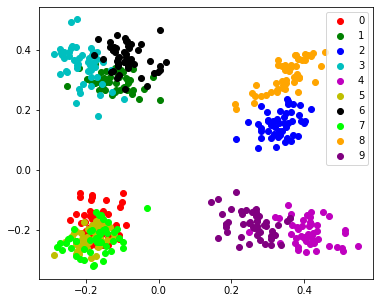

In [38]:
data = torch.eye(10).repeat(50,1)
lab = np.tile(range(10), 50)
f3 = gm(data).detach().numpy()

plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'lime', 'orange', 'purple'
for i, c in zip(target_ids, colors):
    plt.scatter(f3[lab == i, 0], f3[lab == i, 2], c=c, label=str(i))
plt.legend()
plt.show()

# Train

In [13]:
from model.sswae_dev2 import SSWAE_HSIC_MNIST

class SSWAE_HSIC_dev2_1(SSWAE_HSIC_MNIST):
    def __init__(self, cfg, log, device = 'cpu', verbose = 1):
        super(SSWAE_HSIC_dev2_1, self).__init__(cfg, log, device, verbose)
        self.gauss_mixture = prob_gauss_mix(10, self.y_dim).to(device)
        self.gauss_mixture.mu.load_state_dict(torch.load(f'./result/f1_{self.y_dim}.pt'))
        self.gauss_mixture.cov.load_state_dict(torch.load(f'./result/f2_{self.y_dim}.pt'))
    
    def encode_f1(self, y):
        return self.gauss_mixture(y)

In [14]:
from XAE.logging_daily import logging_daily

is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

logger = logging_daily('./config/log_info.yaml')
log = logger.get_logging()
log.setLevel(logging.INFO)

cfg = configparser.ConfigParser()
cfg.read('./config/sswae_dev2_1_1.cfg')

['./config/sswae_dev2_1_1.cfg']

In [15]:
mm = SSWAE_HSIC_dev2_1(cfg, log, device = device)
mm.train()
# mm.load('./%s' % (cfg['path_info']['save_path']))

[default |INFO|_base_model.py:27] ------------------------------------------------------------
[default |INFO|_base_model.py:29] model_name : SSWAE_HSIC_MNIST
[default |INFO|_base_model.py:29] train_data : rmMNIST
[default |INFO|_base_model.py:29] train_data_label : True
[default |INFO|_base_model.py:29] z_sampler : gaus
[default |INFO|_base_model.py:29] z_dim : 6
[default |INFO|_base_model.py:29] y_sampler : gaus
[default |INFO|_base_model.py:29] y_dim : 4
[default |INFO|_base_model.py:29] labeled_class : 0,1,2,3,4,5,6,7,8,9
[default |INFO|_base_model.py:29] unlabeled_class : 
[default |INFO|_base_model.py:29] test_class : 
[default |INFO|_base_model.py:29] portion : 1.0
[default |INFO|_base_model.py:29] encoder_pretrain : False
[default |INFO|_base_model.py:29] encoder_pretrain_step : 3
[default |INFO|_base_model.py:29] lr : 5e-4
[default |INFO|_base_model.py:29] beta1 : 0.5
[default |INFO|_base_model.py:29] lr_adv : 2e-4
[default |INFO|_base_model.py:29] beta1_adv : 0.5
[default |IN

[default |INFO|model.py:1280] [01/80]  loss: 2.384691e-01  D: 6.921271e-01  D2: 2.946118e-02  D3: 4.058289e-03
test loss: 1.758943e-01  D: 6.924422e-01  D2: 5.016022e-03  D3: 6.134510e-03


[default |INFO|model.py:1280] [02/80]  loss: 1.680891e-01  D: 6.956820e-01  D2: 2.338400e-03  D3: 7.360296e-03
test loss: 1.600087e-01  D: 7.171691e-01  D2: 2.657576e-03  D3: 8.999799e-03


[default |INFO|model.py:1280] [03/80]  loss: 1.448981e-01  D: 6.938281e-01  D2: -1.375531e-03  D3: 7.607141e-03
test loss: 1.297734e-01  D: 6.914111e-01  D2: -3.960133e-03  D3: 7.852308e-03


[default |INFO|model.py:1280] [04/80]  loss: 1.405917e-01  D: 7.063425e-01  D2: -3.442529e-03  D3: 1.165562e-02
test loss: 1.222488e-01  D: 7.133675e-01  D2: -3.213987e-03  D3: 8.843797e-03


[default |INFO|model.py:1280] [05/80]  loss: 1.130412e-01  D: 6.954387e-01  D2: -4.110365e-03  D3: 1.035472e-02
test loss: 1.080754e-01  D: 7.065847e-01  D2: -4.213858e-03  D3: 1.198182e-02


[default |INFO|model.py:1280] [06/80]  loss: 1.032250e-01  D: 6.931565e-01  D2: -3.643966e-03  D3: 1.216713e-02
test loss: 1.045917e-01  D: 6.998901e-01  D2: -4.353266e-03  D3: 1.471798e-02


[default |INFO|model.py:1280] [07/80]  loss: 1.107844e-01  D: 6.976094e-01  D2: -3.705365e-03  D3: 1.536382e-02
test loss: 1.029996e-01  D: 6.874069e-01  D2: -4.168816e-03  D3: 1.227871e-02


[default |INFO|model.py:1280] [08/80]  loss: 9.479534e-02  D: 6.938169e-01  D2: -4.140038e-03  D3: 1.114773e-02
test loss: 9.119531e-02  D: 6.860916e-01  D2: -4.151993e-03  D3: 1.474958e-02


[default |INFO|model.py:1280] [09/80]  loss: 9.042187e-02  D: 6.939877e-01  D2: -3.858180e-03  D3: 1.463965e-02
test loss: 8.504286e-02  D: 7.048612e-01  D2: -4.194927e-03  D3: 1.128126e-02


[default |INFO|model.py:1280] [10/80]  loss: 8.643498e-02  D: 6.937421e-01  D2: -4.342330e-03  D3: 1.400609e-02
test loss: 8.435242e-02  D: 6.948182e-01  D2: -4.408789e-03  D3: 1.373066e-02


[default |INFO|model.py:1280] [11/80]  loss: 8.263084e-02  D: 6.936475e-01  D2: -4.194045e-03  D3: 1.434818e-02
test loss: 8.039496e-02  D: 6.947231e-01  D2: -3.985462e-03  D3: 1.491190e-02


[default |INFO|model.py:1280] [12/80]  loss: 7.885163e-02  D: 6.940996e-01  D2: -4.506820e-03  D3: 1.381810e-02
test loss: 7.449739e-02  D: 6.841051e-01  D2: -4.942360e-03  D3: 1.263995e-02


[default |INFO|model.py:1280] [13/80]  loss: 7.528628e-02  D: 6.937207e-01  D2: -4.638948e-03  D3: 1.402641e-02
test loss: 7.270866e-02  D: 6.921601e-01  D2: -4.510813e-03  D3: 1.303046e-02


[default |INFO|model.py:1280] [14/80]  loss: 7.364975e-02  D: 6.943379e-01  D2: -4.931973e-03  D3: 1.391238e-02
test loss: 7.262259e-02  D: 6.883976e-01  D2: -4.779940e-03  D3: 1.317923e-02


[default |INFO|model.py:1280] [15/80]  loss: 7.303426e-02  D: 6.935542e-01  D2: -4.530802e-03  D3: 1.371094e-02
test loss: 7.067514e-02  D: 6.917041e-01  D2: -4.911928e-03  D3: 1.305010e-02


[default |INFO|model.py:1280] [16/80]  loss: 7.325310e-02  D: 6.942472e-01  D2: -4.786946e-03  D3: 1.312590e-02
test loss: 7.343858e-02  D: 6.878018e-01  D2: -4.989357e-03  D3: 1.074790e-02


[default |INFO|model.py:1280] [17/80]  loss: 7.229471e-02  D: 6.945970e-01  D2: -5.070000e-03  D3: 1.317143e-02
test loss: 7.173028e-02  D: 6.939544e-01  D2: -3.827162e-03  D3: 1.175487e-02


[default |INFO|model.py:1280] [18/80]  loss: 7.066271e-02  D: 6.938310e-01  D2: -5.330122e-03  D3: 1.372917e-02
test loss: 6.918192e-02  D: 6.852479e-01  D2: -4.934168e-03  D3: 1.416822e-02


[default |INFO|model.py:1280] [19/80]  loss: 6.771981e-02  D: 6.936025e-01  D2: -5.063486e-03  D3: 1.349031e-02
test loss: 6.775679e-02  D: 6.866932e-01  D2: -5.332699e-03  D3: 1.394058e-02


[default |INFO|model.py:1280] [20/80]  loss: 6.761735e-02  D: 6.939044e-01  D2: -5.427448e-03  D3: 1.368617e-02
test loss: 6.753629e-02  D: 6.766199e-01  D2: -5.447550e-03  D3: 1.346082e-02


[default |INFO|model.py:1280] [21/80]  loss: 6.689138e-02  D: 6.935123e-01  D2: -5.489078e-03  D3: 1.344502e-02
test loss: 6.848687e-02  D: 6.931039e-01  D2: -5.643520e-03  D3: 1.378852e-02


[default |INFO|model.py:1280] [22/80]  loss: 6.613075e-02  D: 6.935870e-01  D2: -5.563318e-03  D3: 1.339317e-02
test loss: 6.632809e-02  D: 6.777528e-01  D2: -6.203585e-03  D3: 1.301621e-02


[default |INFO|model.py:1280] [23/80]  loss: 6.541650e-02  D: 6.940091e-01  D2: -6.009162e-03  D3: 1.309487e-02
test loss: 6.509033e-02  D: 6.864826e-01  D2: -5.887842e-03  D3: 1.331011e-02


[default |INFO|model.py:1280] [24/80]  loss: 6.429474e-02  D: 6.932889e-01  D2: -6.002666e-03  D3: 1.313011e-02
test loss: 6.546488e-02  D: 6.926635e-01  D2: -5.431890e-03  D3: 1.257877e-02


[default |INFO|model.py:1280] [25/80]  loss: 6.416613e-02  D: 6.936068e-01  D2: -6.135515e-03  D3: 1.306878e-02
test loss: 6.349501e-02  D: 6.935410e-01  D2: -6.716309e-03  D3: 1.288243e-02


[default |INFO|model.py:1280] [26/80]  loss: 6.373798e-02  D: 6.937533e-01  D2: -6.303387e-03  D3: 1.307762e-02
test loss: 6.417521e-02  D: 6.762461e-01  D2: -5.862064e-03  D3: 1.354035e-02


[default |INFO|model.py:1280] [27/80]  loss: 6.418467e-02  D: 6.935756e-01  D2: -6.282412e-03  D3: 1.321306e-02
test loss: 6.302673e-02  D: 7.017740e-01  D2: -6.106939e-03  D3: 1.407988e-02


[default |INFO|model.py:1280] [28/80]  loss: 6.336432e-02  D: 6.933023e-01  D2: -6.563630e-03  D3: 1.308294e-02
test loss: 6.566133e-02  D: 6.876612e-01  D2: -6.143522e-03  D3: 1.163461e-02


[default |INFO|model.py:1280] [29/80]  loss: 6.397005e-02  D: 6.936485e-01  D2: -6.668396e-03  D3: 1.292700e-02
test loss: 6.282990e-02  D: 7.061823e-01  D2: -6.531992e-03  D3: 1.239462e-02


[default |INFO|model.py:1280] [30/80]  loss: 6.294661e-02  D: 6.939607e-01  D2: -6.586507e-03  D3: 1.290572e-02
test loss: 6.273829e-02  D: 7.080328e-01  D2: -6.638956e-03  D3: 1.312193e-02


[default |INFO|model.py:1280] [31/80]  loss: 6.311533e-02  D: 6.935029e-01  D2: -6.622791e-03  D3: 1.269532e-02
test loss: 6.515600e-02  D: 6.900672e-01  D2: -6.575193e-03  D3: 1.326711e-02


[default |INFO|model.py:1280] [32/80]  loss: 6.242457e-02  D: 6.935120e-01  D2: -6.968080e-03  D3: 1.284411e-02
test loss: 6.142655e-02  D: 6.869391e-01  D2: -7.053995e-03  D3: 1.296985e-02


[default |INFO|model.py:1280] [33/80]  loss: 6.240180e-02  D: 6.934607e-01  D2: -7.080765e-03  D3: 1.254489e-02
test loss: 6.109406e-02  D: 6.883001e-01  D2: -6.938152e-03  D3: 1.315961e-02


[default |INFO|model.py:1280] [34/80]  loss: 6.110426e-02  D: 6.936539e-01  D2: -7.141527e-03  D3: 1.283934e-02
test loss: 6.380121e-02  D: 6.942661e-01  D2: -7.078657e-03  D3: 1.259982e-02


[default |INFO|model.py:1280] [35/80]  loss: 6.153959e-02  D: 6.933977e-01  D2: -7.053545e-03  D3: 1.264539e-02
test loss: 6.282633e-02  D: 6.976836e-01  D2: -7.035732e-03  D3: 1.203199e-02


[default |INFO|model.py:1280] [36/80]  loss: 6.097376e-02  D: 6.938430e-01  D2: -7.053863e-03  D3: 1.267065e-02
test loss: 6.257031e-02  D: 6.981501e-01  D2: -7.290792e-03  D3: 1.361363e-02


[default |INFO|model.py:1280] [37/80]  loss: 6.170444e-02  D: 6.933222e-01  D2: -7.387336e-03  D3: 1.259520e-02
test loss: 6.116818e-02  D: 6.854290e-01  D2: -7.121763e-03  D3: 1.333884e-02


[default |INFO|model.py:1280] [38/80]  loss: 6.065273e-02  D: 6.931531e-01  D2: -7.374595e-03  D3: 1.264307e-02
test loss: 6.154013e-02  D: 6.818728e-01  D2: -7.187376e-03  D3: 1.359701e-02


[default |INFO|model.py:1280] [39/80]  loss: 6.068492e-02  D: 6.936907e-01  D2: -7.466930e-03  D3: 1.234749e-02
test loss: 6.319549e-02  D: 6.951100e-01  D2: -7.437725e-03  D3: 1.187936e-02


[default |INFO|model.py:1280] [40/80]  loss: 6.070866e-02  D: 6.931681e-01  D2: -7.415082e-03  D3: 1.268783e-02
test loss: 6.412666e-02  D: 6.952747e-01  D2: -7.188311e-03  D3: 1.212444e-02


[default |INFO|model.py:1280] [41/80]  loss: 6.006557e-02  D: 6.935102e-01  D2: -7.491442e-03  D3: 1.243025e-02
test loss: 6.073128e-02  D: 6.937420e-01  D2: -7.759533e-03  D3: 1.326430e-02


[default |INFO|model.py:1280] [42/80]  loss: 5.971465e-02  D: 6.935220e-01  D2: -7.600848e-03  D3: 1.248337e-02
test loss: 5.981542e-02  D: 6.984273e-01  D2: -7.828197e-03  D3: 1.353158e-02


[default |INFO|model.py:1280] [43/80]  loss: 5.899306e-02  D: 6.933927e-01  D2: -7.816962e-03  D3: 1.249213e-02
test loss: 6.066734e-02  D: 6.975624e-01  D2: -7.812157e-03  D3: 1.332583e-02


[default |INFO|model.py:1280] [44/80]  loss: 5.955236e-02  D: 6.929210e-01  D2: -7.853559e-03  D3: 1.247534e-02
test loss: 6.117639e-02  D: 6.889620e-01  D2: -7.420359e-03  D3: 1.278243e-02


[default |INFO|model.py:1280] [45/80]  loss: 5.900168e-02  D: 6.937972e-01  D2: -7.946814e-03  D3: 1.234549e-02
test loss: 6.160127e-02  D: 6.942789e-01  D2: -8.069792e-03  D3: 1.316878e-02


[default |INFO|model.py:1280] [46/80]  loss: 5.896681e-02  D: 6.932730e-01  D2: -7.885666e-03  D3: 1.234016e-02
test loss: 6.139156e-02  D: 6.866480e-01  D2: -7.416277e-03  D3: 1.398047e-02


[default |INFO|model.py:1280] [47/80]  loss: 5.940761e-02  D: 6.936389e-01  D2: -7.964824e-03  D3: 1.220827e-02
test loss: 6.100736e-02  D: 7.014963e-01  D2: -7.276640e-03  D3: 1.390879e-02


[default |INFO|model.py:1280] [48/80]  loss: 5.915857e-02  D: 6.932409e-01  D2: -7.977880e-03  D3: 1.213316e-02
test loss: 5.980390e-02  D: 6.828635e-01  D2: -8.030872e-03  D3: 1.319139e-02


[default |INFO|model.py:1280] [49/80]  loss: 5.887930e-02  D: 6.931991e-01  D2: -8.078696e-03  D3: 1.224534e-02
test loss: 6.329035e-02  D: 6.799881e-01  D2: -7.971792e-03  D3: 1.103531e-02


[default |INFO|model.py:1280] [50/80]  loss: 5.927433e-02  D: 6.931425e-01  D2: -8.113519e-03  D3: 1.218568e-02
test loss: 6.125554e-02  D: 6.861022e-01  D2: -8.222370e-03  D3: 1.184405e-02


[default |INFO|model.py:1280] [51/80]  loss: 5.883094e-02  D: 6.931609e-01  D2: -8.203290e-03  D3: 1.224868e-02
test loss: 6.088083e-02  D: 6.856765e-01  D2: -8.347721e-03  D3: 1.122372e-02


[default |INFO|model.py:1280] [52/80]  loss: 5.814028e-02  D: 6.936155e-01  D2: -8.415834e-03  D3: 1.223631e-02
test loss: 6.080878e-02  D: 6.806298e-01  D2: -7.681761e-03  D3: 1.228221e-02


[default |INFO|model.py:1280] [53/80]  loss: 5.829668e-02  D: 6.934394e-01  D2: -8.280360e-03  D3: 1.213474e-02
test loss: 6.018335e-02  D: 6.943318e-01  D2: -8.289051e-03  D3: 1.135284e-02


[default |INFO|model.py:1280] [54/80]  loss: 5.803144e-02  D: 6.932883e-01  D2: -8.312689e-03  D3: 1.207395e-02
test loss: 5.890265e-02  D: 6.933763e-01  D2: -7.916298e-03  D3: 1.223320e-02


[default |INFO|model.py:1280] [55/80]  loss: 5.793671e-02  D: 6.936231e-01  D2: -8.284151e-03  D3: 1.209673e-02
test loss: 6.093507e-02  D: 6.960202e-01  D2: -7.773170e-03  D3: 1.179617e-02


[default |INFO|model.py:1280] [56/80]  loss: 5.701616e-02  D: 6.928014e-01  D2: -8.378684e-03  D3: 1.230292e-02
test loss: 5.899561e-02  D: 6.945467e-01  D2: -8.705273e-03  D3: 1.217699e-02


[default |INFO|model.py:1280] [57/80]  loss: 5.760278e-02  D: 6.936228e-01  D2: -8.494620e-03  D3: 1.210914e-02
test loss: 5.959656e-02  D: 6.927797e-01  D2: -7.790298e-03  D3: 1.326002e-02


[default |INFO|model.py:1280] [58/80]  loss: 5.769015e-02  D: 6.931313e-01  D2: -8.522860e-03  D3: 1.201133e-02
test loss: 5.925599e-02  D: 7.058876e-01  D2: -8.305130e-03  D3: 1.244980e-02


[default |INFO|model.py:1280] [59/80]  loss: 5.810568e-02  D: 6.927611e-01  D2: -8.484424e-03  D3: 1.190224e-02
test loss: 6.065089e-02  D: 6.928905e-01  D2: -7.918358e-03  D3: 1.300004e-02


[default |INFO|model.py:1280] [60/80]  loss: 5.727202e-02  D: 6.934964e-01  D2: -8.593351e-03  D3: 1.189272e-02
test loss: 6.252564e-02  D: 6.768119e-01  D2: -8.215256e-03  D3: 1.455650e-02


[default |INFO|model.py:1280] [61/80]  loss: 5.687108e-02  D: 6.929486e-01  D2: -8.567125e-03  D3: 1.204351e-02
test loss: 5.920962e-02  D: 6.925728e-01  D2: -8.368788e-03  D3: 1.281277e-02


[default |INFO|model.py:1280] [62/80]  loss: 5.673002e-02  D: 6.934476e-01  D2: -8.633676e-03  D3: 1.211157e-02
test loss: 5.970726e-02  D: 6.936313e-01  D2: -8.563080e-03  D3: 1.167933e-02


[default |INFO|model.py:1280] [63/80]  loss: 5.666684e-02  D: 6.928443e-01  D2: -8.662230e-03  D3: 1.195801e-02
test loss: 5.929478e-02  D: 6.956941e-01  D2: -8.007536e-03  D3: 1.177402e-02


[default |INFO|model.py:1280] [64/80]  loss: 5.683486e-02  D: 6.933320e-01  D2: -8.718044e-03  D3: 1.200486e-02
test loss: 6.060414e-02  D: 6.908662e-01  D2: -8.575678e-03  D3: 1.035412e-02


[default |INFO|model.py:1280] [65/80]  loss: 5.786142e-02  D: 6.936157e-01  D2: -8.660399e-03  D3: 1.174696e-02
test loss: 5.854148e-02  D: 6.904812e-01  D2: -8.525467e-03  D3: 1.213512e-02


[default |INFO|model.py:1280] [66/80]  loss: 5.654300e-02  D: 6.933832e-01  D2: -8.712540e-03  D3: 1.200175e-02
test loss: 5.870201e-02  D: 7.029679e-01  D2: -8.244228e-03  D3: 1.161573e-02


[default |INFO|model.py:1280] [67/80]  loss: 5.618472e-02  D: 6.936736e-01  D2: -8.782156e-03  D3: 1.202995e-02
test loss: 5.859707e-02  D: 6.881400e-01  D2: -8.468742e-03  D3: 1.289020e-02


[default |INFO|model.py:1280] [68/80]  loss: 5.660751e-02  D: 6.932303e-01  D2: -8.790043e-03  D3: 1.178155e-02
test loss: 5.905520e-02  D: 6.707208e-01  D2: -8.687801e-03  D3: 1.308241e-02


[default |INFO|model.py:1280] [69/80]  loss: 5.718530e-02  D: 6.935682e-01  D2: -8.783032e-03  D3: 1.172519e-02
test loss: 5.910797e-02  D: 6.884053e-01  D2: -8.330784e-03  D3: 1.322719e-02


[default |INFO|model.py:1280] [70/80]  loss: 5.628773e-02  D: 6.929351e-01  D2: -8.836158e-03  D3: 1.182027e-02
test loss: 5.803155e-02  D: 7.026386e-01  D2: -8.603325e-03  D3: 1.317529e-02


[default |INFO|model.py:1280] [71/80]  loss: 5.629839e-02  D: 6.927747e-01  D2: -8.808233e-03  D3: 1.174796e-02
test loss: 5.936322e-02  D: 6.906214e-01  D2: -8.818769e-03  D3: 1.188055e-02


[default |INFO|model.py:1280] [72/80]  loss: 5.590490e-02  D: 6.941573e-01  D2: -8.853242e-03  D3: 1.185337e-02
test loss: 5.888150e-02  D: 6.973338e-01  D2: -8.718939e-03  D3: 1.200139e-02


[default |INFO|model.py:1280] [73/80]  loss: 5.604428e-02  D: 6.937453e-01  D2: -8.854017e-03  D3: 1.183535e-02
test loss: 5.852871e-02  D: 6.885935e-01  D2: -8.471041e-03  D3: 1.195666e-02


[default |INFO|model.py:1280] [74/80]  loss: 5.578247e-02  D: 6.930284e-01  D2: -8.879759e-03  D3: 1.183960e-02
test loss: 5.784980e-02  D: 6.729306e-01  D2: -8.852921e-03  D3: 1.232735e-02


[default |INFO|model.py:1280] [75/80]  loss: 5.543253e-02  D: 6.935598e-01  D2: -8.891387e-03  D3: 1.186013e-02
test loss: 5.940766e-02  D: 6.971051e-01  D2: -9.050589e-03  D3: 1.149804e-02


[default |INFO|model.py:1280] [76/80]  loss: 5.526654e-02  D: 6.933505e-01  D2: -8.918630e-03  D3: 1.181701e-02
test loss: 5.999023e-02  D: 6.846094e-01  D2: -8.241863e-03  D3: 1.248622e-02


[default |INFO|model.py:1280] [77/80]  loss: 5.585378e-02  D: 6.933702e-01  D2: -8.853850e-03  D3: 1.165531e-02
test loss: 5.861176e-02  D: 6.945622e-01  D2: -8.910961e-03  D3: 1.251375e-02


[default |INFO|model.py:1280] [78/80]  loss: 5.538547e-02  D: 6.933879e-01  D2: -8.895429e-03  D3: 1.182086e-02
test loss: 5.906844e-02  D: 6.870005e-01  D2: -8.799782e-03  D3: 1.103604e-02


[default |INFO|model.py:1280] [79/80]  loss: 5.592613e-02  D: 6.935893e-01  D2: -8.915950e-03  D3: 1.161738e-02
test loss: 5.893595e-02  D: 6.986245e-01  D2: -8.521376e-03  D3: 1.270684e-02


[default |INFO|model.py:1280] [80/80]  loss: 5.593152e-02  D: 6.936559e-01  D2: -8.980219e-03  D3: 1.171755e-02
test loss: 5.753723e-02  D: 7.029828e-01  D2: -8.805914e-03  D3: 1.228035e-02


[default |INFO|model.py:1351] Training Finished!
[default |INFO|model.py:1352] Elapsed time: 3144.868s


# Test

In [16]:
batch_size = 100
test_data = MNIST(cfg['path_info']['data_home'], train = False, label = True)
test_generator = torch.utils.data.DataLoader(test_data, batch_size, num_workers = 5, shuffle = False, pin_memory=True, drop_last=True)
n = len(test_generator)

In [17]:
test_iter = iter(test_generator)
true_label = np.zeros(n*batch_size)
lab_t = torch.Tensor(range(10))
for i in range(n):
    img, lab = next(test_iter)
    true_label[(i*batch_size):((i+1)*batch_size)] = (lab_t*lab).sum(dim=1).detach().numpy()


In [18]:
target = []
n = len(true_label)
for i in range(10):
    target_d = np.arange(n)[true_label == i]
    target.append(target_d[1])
target
x = torch.Tensor(np.concatenate([np.array(test_data[i][0]) for i in target])).unsqueeze(1).to(device)
z = mm.encode(x)
recon = mm.decode(z).squeeze(1).detach().to('cpu').numpy()

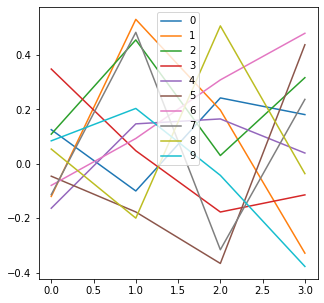

In [19]:
fig, ax = plt.subplots(figsize = (5.0, 5.0))
for i in range(10):
    ax.plot(z[i, 0:mm.y_dim].detach().to('cpu').numpy(), label = "%s" % i)
plt.legend()
plt.show()

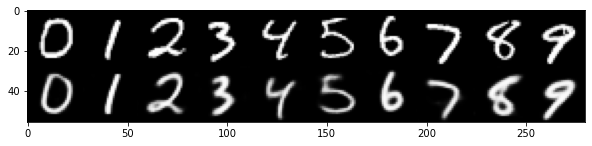

In [20]:
sample_data = []

sample_data.append(np.concatenate([test_data[i][0].numpy()[0,:,:] for i in target], axis = 1))
sample_data.append(np.concatenate([recon[i,:,:] for i in range(10)], axis = 1))
sample_data = np.concatenate(sample_data, axis = 0)
fig = plt.figure(figsize=(10.0,10.0))
plt.imshow(sample_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.show()

# Sample Generation

## 1. Exemplar Generation

In [24]:
from XAE.sampler import gaus

exn = 5

In [25]:
zz = torch.cat((torch.zeros(1,mm.z_dim), gaus(exn,mm.z_dim)), dim = 0).to(device)
new_z = torch.cat((z[:,0:mm.y_dim].repeat_interleave(exn + 1, dim = 0).to(device), zz.repeat((10, 1))), dim = 1)
new_x = mm.decode(new_z).squeeze(1).detach().to('cpu').numpy()

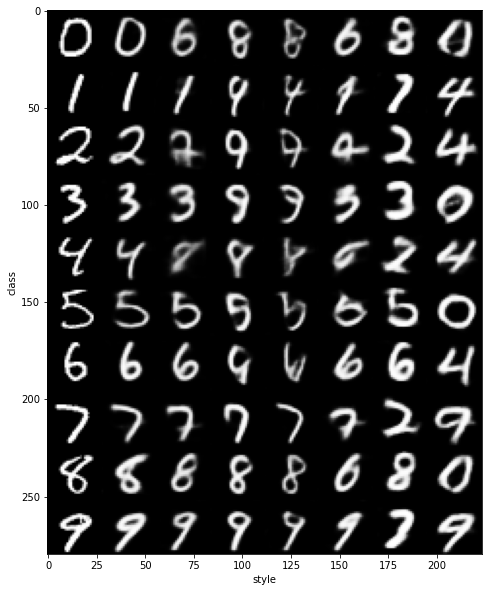

In [26]:
img_data = []
for i in range(10):
    img_data.append(np.concatenate([test_data[target[i]][0].numpy()[0,:,:]] + [recon[i,:,:]] + [new_x[(exn+1)*i + j] for j in range(exn+1)], axis = 1))
img_data = np.concatenate(img_data, axis = 0)

fig, ax = plt.subplots(figsize = (10.0, 10.0))
ax.imshow(img_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.xlabel('style')
plt.ylabel('class')
plt.show()

## 2. Style Transfer

In [27]:
new_z = torch.cat((z[:,:mm.y_dim].repeat_interleave(10, dim = 0), z[:,mm.y_dim:].repeat((10, 1))), dim = 1)
new_x = mm.decode(new_z).squeeze(1).detach().to('cpu').numpy()

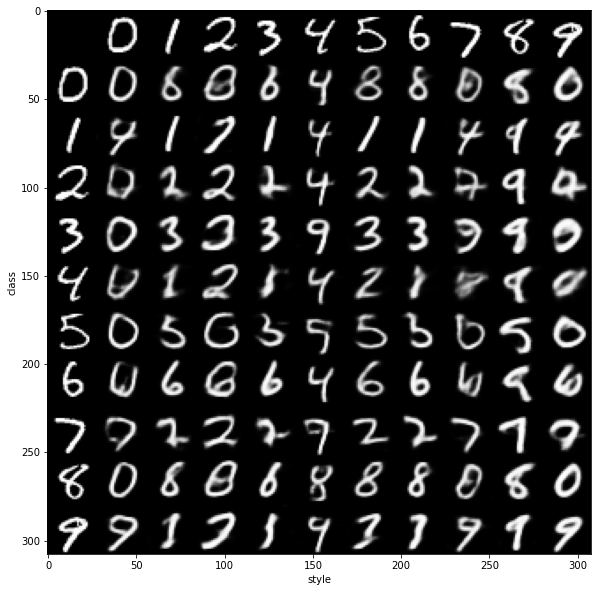

In [28]:
img_data = np.ones((28*11, 28*11))*-1
img_data[:28,28:] = np.concatenate([test_data[i][0].numpy()[0,:,:] for i in target], axis = 1)
for i in range(10):
    img_data[((i+1)*28):((i+2)*28),:28] = test_data[target[i]][0].numpy()[0,:,:]
    img_data[((i+1)*28):((i+2)*28),28:] = np.concatenate(new_x[(10*i):(10*(i+1)),:,:], axis = 1)

fig, ax = plt.subplots(figsize = (10.0, 10.0))
ax.imshow(img_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.xlabel('style')
plt.ylabel('class')
plt.show()